# W3C IIS logs analysis
This notebook analyzes IIS logs and generates a detailed report containing everything from total log file size, status codes breakdown, user agent interpretations to box plots of the response time.

Simply set the path to the IIS log folder and run the notebook.

You can use the testing log files provided in the `test_logs` folder or generate sample logs using my IIS log generator script [here](

Read more about the IIS [W3C Extended Log File Format](https://www.w3.org/TR/WD-logfile.html) [here](https://learn.microsoft.com/en-us/previous-versions/iis/6.0-sdk/ms525807(v=vs.90)).

## Importing libraries

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from user_agent_parser import Parser
import requests
import json

# Variables
Change these variables to match your environment and needs

- logs_path - Path to the IIS log file folder
- memory_limit - Loads newest->oldest log files until memory_limit is reached (in MB)

In [13]:
logs_path = os.getcwd() + '/test_logs'
memory_limit = 512

# Preparation and data loading

## Loading log files

### Functions for loading log files

In [14]:
# Convert log file name like u_ex220804.log to date (in format DD-MM-YY) 
def get_log_date(log):
    date = log.split('.')[0].split('_')[1]
    return '{}-{}-{}'.format(date[6:8], date[4:6], date[2:4])

# Function for loading a log file that returns all lines.
def load_log_file(f_path):
    columns = []
    with open(f_path, 'r') as f:
        lines = f.readlines()
    return lines

In [15]:
# Get all the log files in the folder
log_files = [f for f in os.listdir(logs_path) if f.endswith('.log')]
log_files.sort(reverse=True)
print('Found {} log files'.format(len(log_files)))

# Print time range
print('Time range: {} to {}'.format(get_log_date(log_files[-1]), get_log_date(log_files[1])))

# Get total and average size of log files
total_size = sum(os.path.getsize(os.path.join(logs_path, f)) for f in log_files)
print('Total size: {:.2f} MB'.format(total_size / 1024 / 1024))
print('Average size: {:.2f} MB'.format(total_size / 1024 / 1024 / len(log_files)))
    
# Load newest->oldest until memory limit is reached
allLines = []
for f in log_files:
    f_path = os.path.join(logs_path, f)
    lines = load_log_file(f_path)
    allLines += lines
    
    # Check memory usage
    mem = sum([sys.getsizeof(l) for l in allLines]) / 1024 / 1024
    if mem > memory_limit:
        print('Memory limit reached at {:.2f} MB'.format(mem))
        break
    
print('Loaded {} lines'.format(len(allLines)))
print('Memory usage: {:.2f} MB'.format(mem))

# Remove empty lines
allLines = [l for l in allLines if l.strip()]

# Get unique column names by searching all lines for 
# "#Fields: " and then splitting the line by spaces and removing the first element
columns = [l for l in allLines if l.startswith('#Fields:')][0].split(' ')[1:]

# Replace '\n' with '' and remove empty elements
columns = [c.replace('\n', '') for c in columns if c]
print('Found {} columns'.format(len(columns)))

# Remove all lines that start with # and add the remaining lines to the dataframe
allLines = [l for l in allLines if not l.startswith('#')]
df = pd.DataFrame([l.split(' ') for l in allLines], columns=columns)

# Convert to all string columns to lowercase
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].str.lower()
        
# Set data types
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['time-taken'] = pd.to_numeric(df['time-taken'])



# Sort by date
df = df.sort_values(by='date')

Found 15 log files
Time range: 02-12-22 to 06-01-23
Total size: 14.45 MB
Average size: 0.96 MB
Loaded 78011 lines
Memory usage: 18.10 MB
Found 15 columns


# Analysis


## Traffic

## HTTP(S) requests

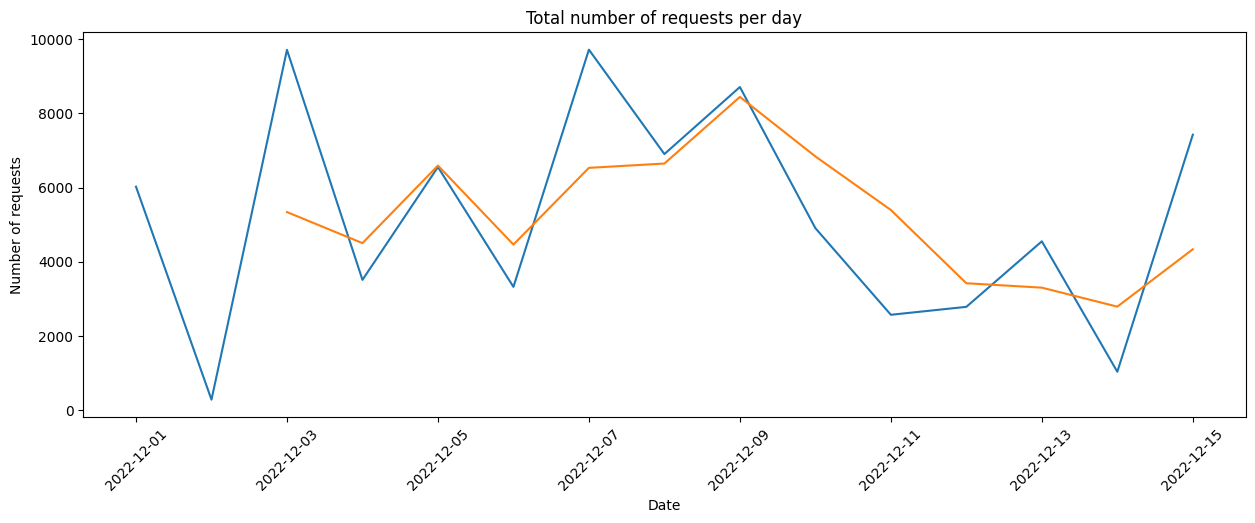

In [31]:
# Plot of number of requests per day over time (including rolling average of 7 days)
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='count', data=df.groupby('date').size().reset_index(name='count')).set(title='Total number of requests per day', xlabel='Date', ylabel='Number of requests')
sns.lineplot(x='date', y='count', data=df.groupby('date').size().rolling(3).mean().reset_index(name='count'))
plt.xticks(rotation=45)
plt.show()

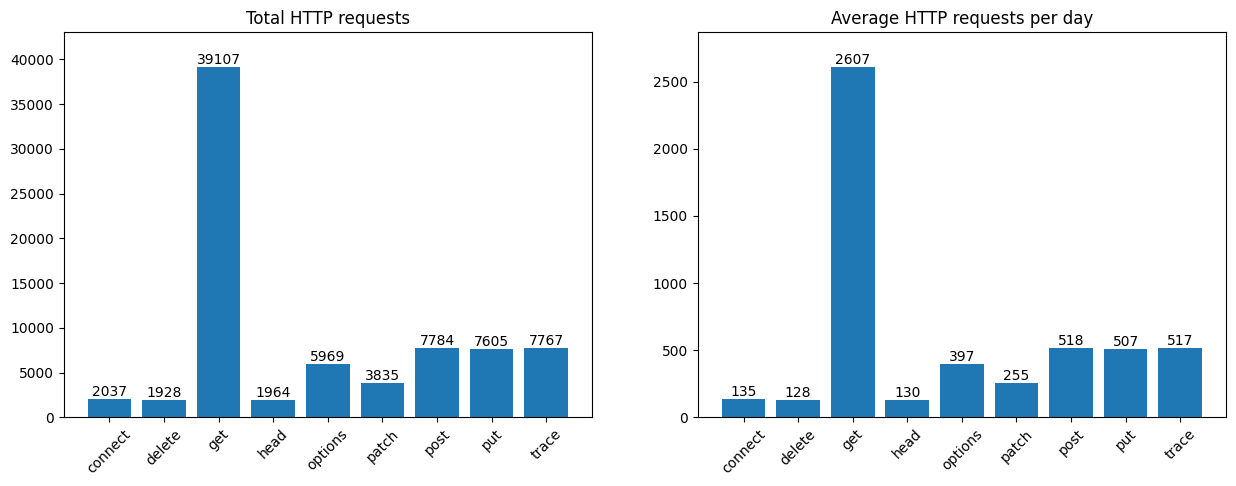

In [17]:
# Bar plot of total and average count for each type of HTTP request method
plt.figure(figsize=(15, 5))

# Show total and average in two plots next to each other
plt.subplot(1, 2, 1)
plt.title('Total HTTP requests')
totalrequests = df.groupby('cs-method')['cs-method'].count()
plt.bar(totalrequests.index, totalrequests)
plt.xticks(rotation=45)
plt.ylim(0, totalrequests.max() * 1.1)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

for i, v in enumerate(totalrequests):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.subplot(1, 2, 2)
plt.title('Average HTTP requests per day')
meanrequests = totalrequests / len(df['date'].unique())
meanrequests = meanrequests.astype(int)
plt.bar(meanrequests.index, meanrequests)
plt.xticks(rotation=45)
plt.ylim(0, meanrequests.max() * 1.1)
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

for i, v in enumerate(meanrequests):
    plt.text(i, v, str(v), ha='center', va='bottom')


plt.show()

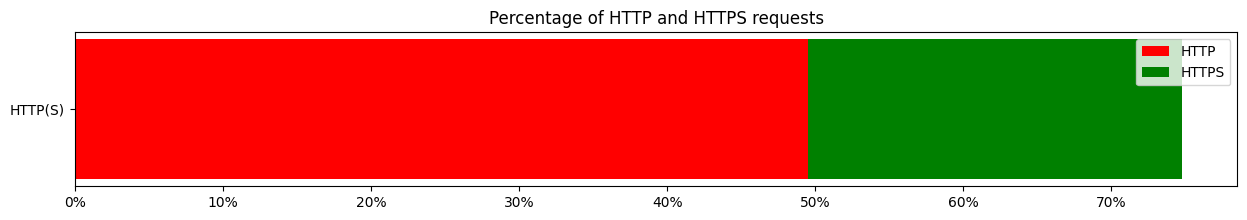

In [18]:
# Stacked bar plot of % HTTP & HTTPS requests
# S-port 443 is HTTPS and 80 is HTTP
plt.figure(figsize=(15, 2))
plt.title('Percentage of HTTP and HTTPS requests')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}%'))

http = df[df['s-port'] == '80']
https = df[df['s-port'] == '443']

plt.barh('HTTP(S)', http.shape[0] / df.shape[0] * 100, color='red')
plt.barh('HTTP(S)', https.shape[0] / df.shape[0] * 100, left=http.shape[0] / df.shape[0] * 100, color='green')

plt.legend(['HTTP', 'HTTPS'])

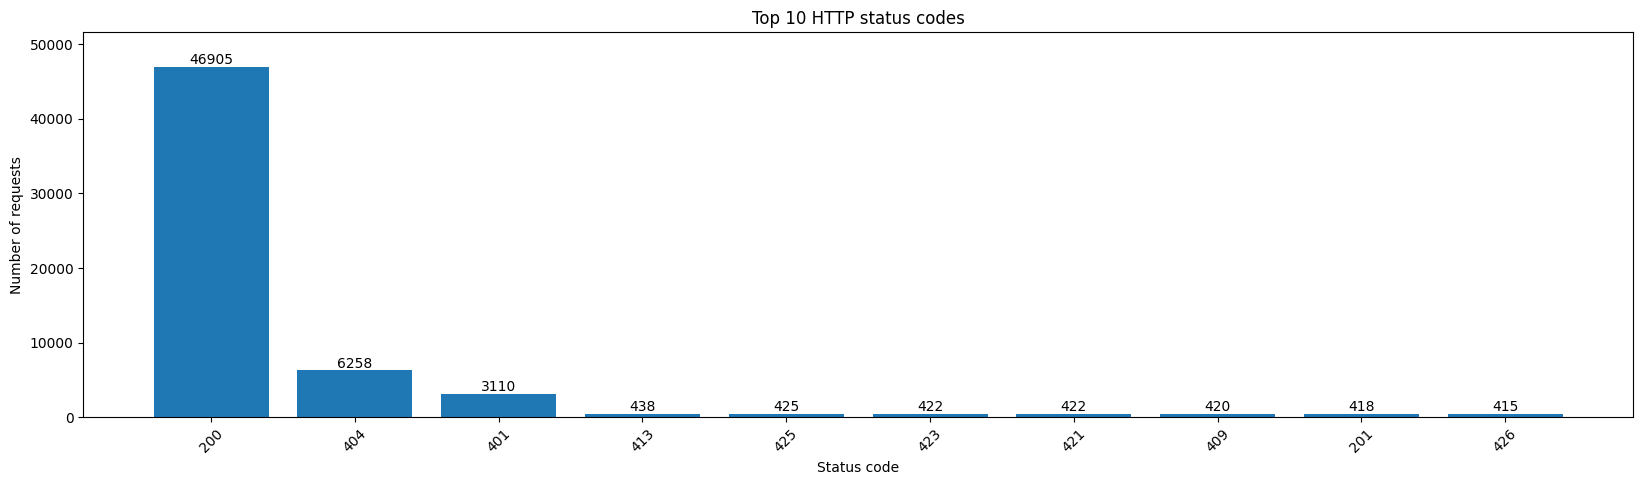

In [19]:
# Bar plot of top 10 HTTP status codes (sc-status)
plt.figure(figsize=(20, 5))
plt.title('Top 10 HTTP status codes')
plt.xlabel('Status code')
plt.ylabel('Number of requests')
statuscodes = df['sc-status'].value_counts().head(10)
plt.bar(statuscodes.index, statuscodes)
plt.xticks(rotation=45)
plt.ylim(0, statuscodes.max() * 1.1)

for i, v in enumerate(statuscodes):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

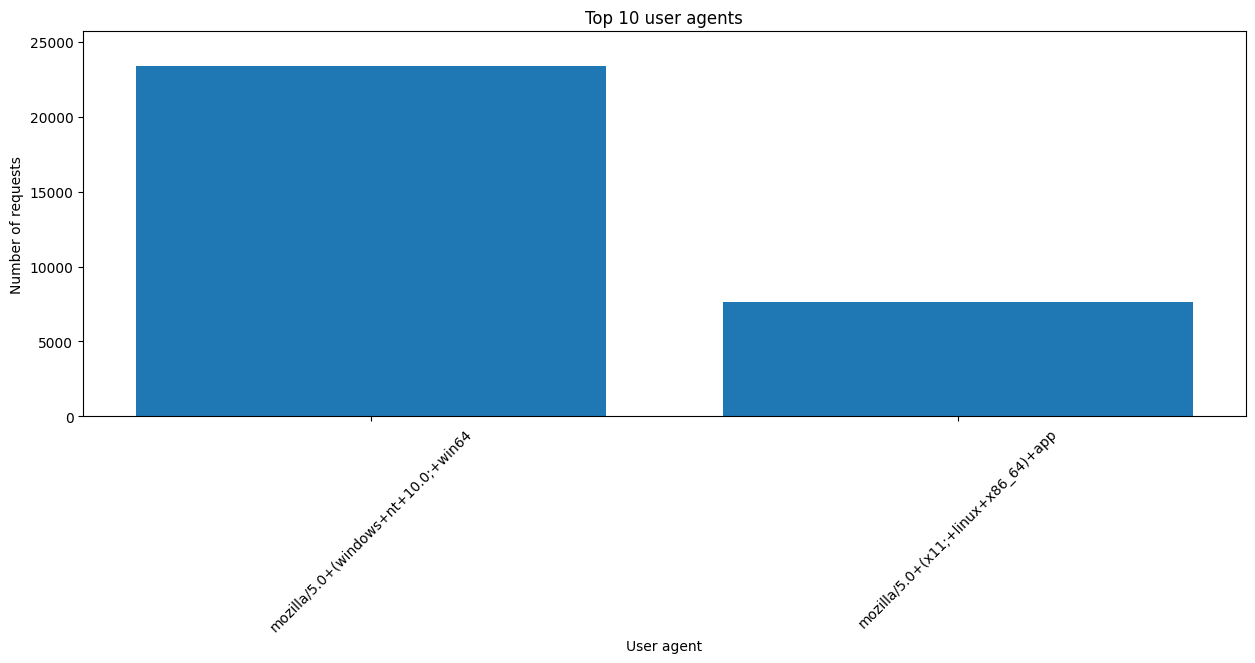

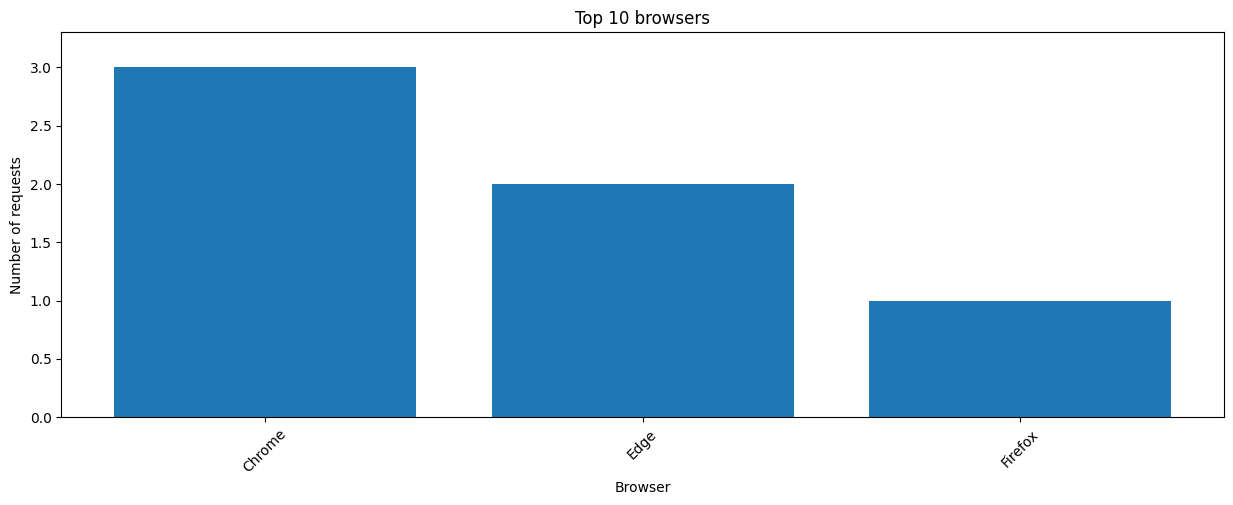

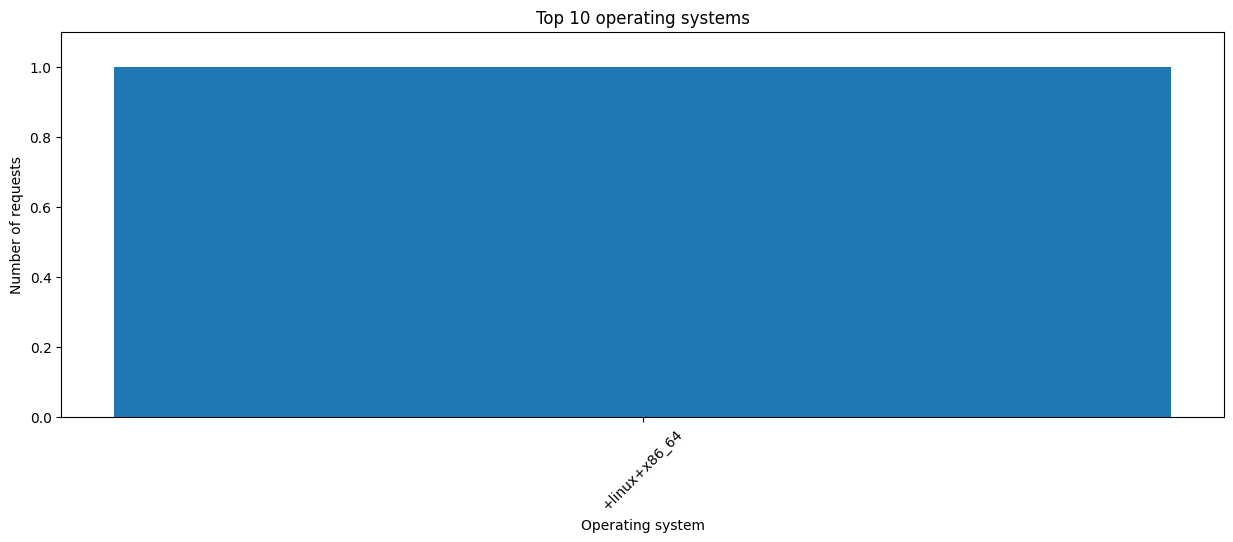

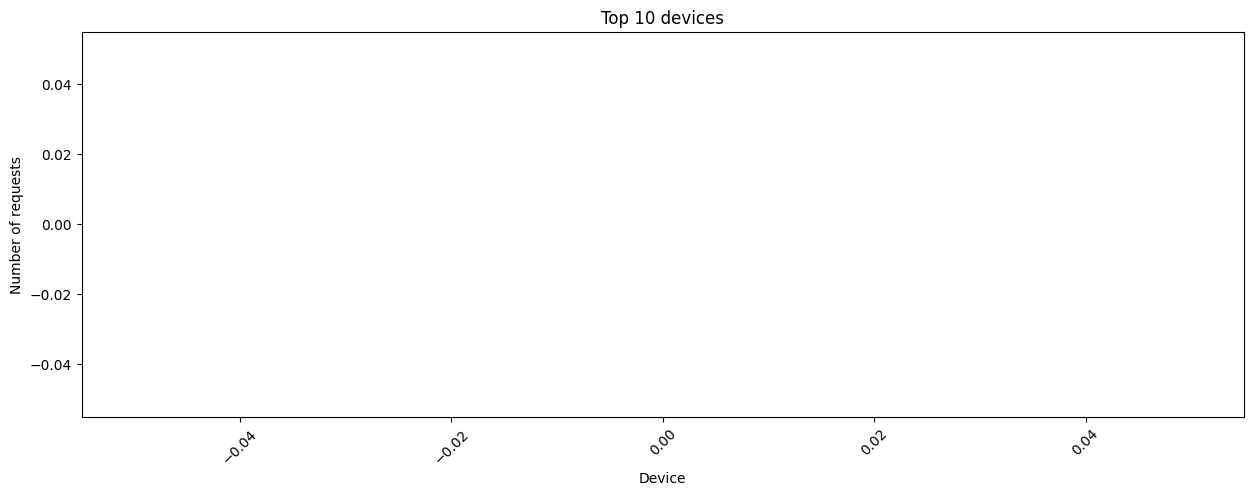

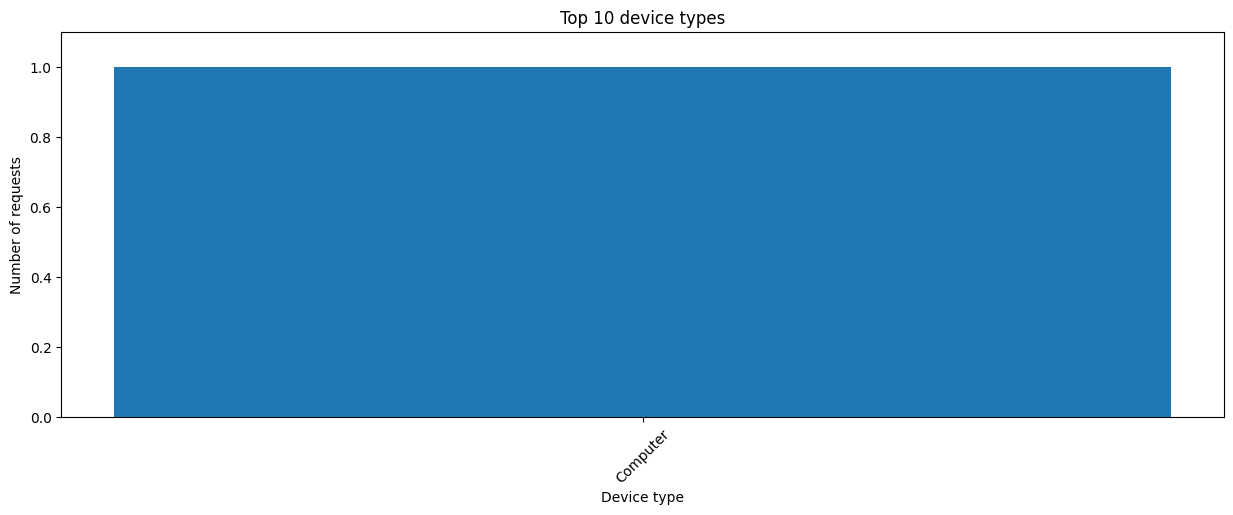

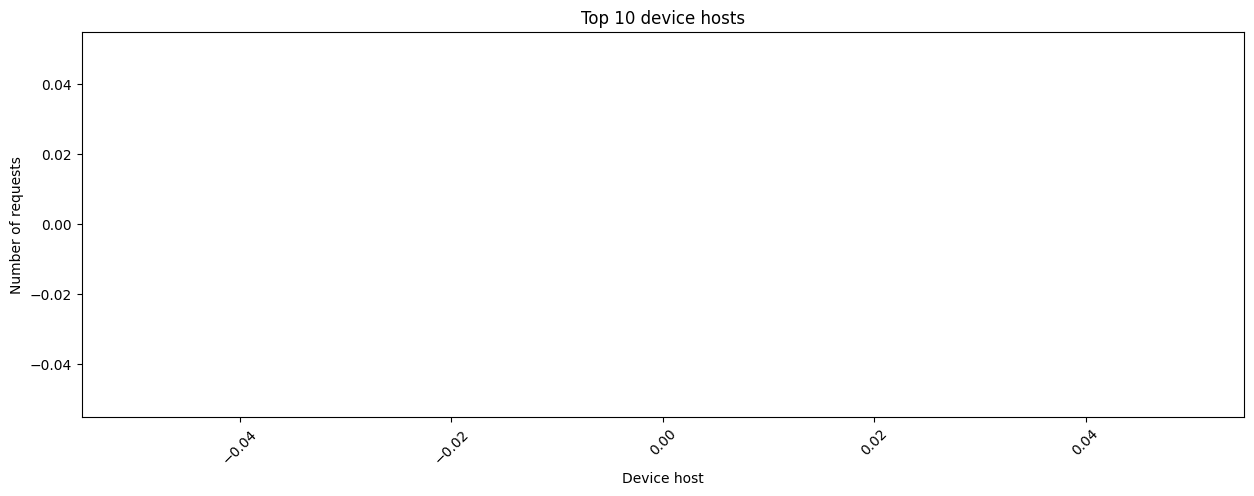

In [20]:
# Bar plot of top 10 user agent strings (substring first 35 characters)
plt.figure(figsize=(15, 5))
plt.title('Top 10 user agents')
plt.xlabel('User agent')
plt.ylabel('Number of requests')
topuseragents = df['cs(User-Agent)'].value_counts().head(10)
topuseragents.index = topuseragents.index.str[:35]
plt.bar(topuseragents.index, topuseragents)
plt.xticks(rotation=45)
plt.ylim(0, topuseragents.max() * 1.1)

# Bar plot of top 10 user agents parsed
ua_parsed = df['cs(User-Agent)'].value_counts().head(10).index.to_series().apply(lambda x: Parser(x))

# Browser
browsers = ua_parsed.apply(lambda x: x.browser)
plt.figure(figsize=(15, 5))
plt.title('Top 10 browsers')
plt.xlabel('Browser')
plt.ylabel('Number of requests')
topbrowsers = browsers.value_counts()[:10]
plt.bar(topbrowsers.index, topbrowsers)
plt.xticks(rotation=45)
plt.ylim(0, topbrowsers.max() * 1.1)

# OS
os = ua_parsed.apply(lambda x: x.os)
plt.figure(figsize=(15, 5))
plt.title('Top 10 operating systems')
plt.xlabel('Operating system')
plt.ylabel('Number of requests')
topos = os.value_counts()[:10]
plt.bar(topos.index, topos)
plt.xticks(rotation=45)
plt.ylim(0, topos.max() * 1.1)

# Device
devices = ua_parsed.apply(lambda x: x.device_name)
plt.figure(figsize=(15, 5))
plt.title('Top 10 devices')
plt.xlabel('Device')
plt.ylabel('Number of requests')
topdevices = devices.value_counts()[:10]
plt.bar(topdevices.index, topdevices)
plt.xticks(rotation=45)

# Device type
devicetypes = ua_parsed.apply(lambda x: x.device_type)
plt.figure(figsize=(15, 5))
plt.title('Top 10 device types')
plt.xlabel('Device type')
plt.ylabel('Number of requests')
topdevicetypes = devicetypes.value_counts()[:10]
plt.bar(topdevicetypes.index, topdevicetypes)
plt.xticks(rotation=45)
plt.ylim(0, topdevicetypes.max() * 1.1)

# Device host
devicehosts = ua_parsed.apply(lambda x: x.device_host)
plt.figure(figsize=(15, 5))
plt.title('Top 10 device hosts')
plt.xlabel('Device host')
plt.ylabel('Number of requests')
topdevicehosts = devicehosts.value_counts()[:10]
plt.bar(topdevicehosts.index, topdevicehosts)
plt.xticks(rotation=45)

plt.show()

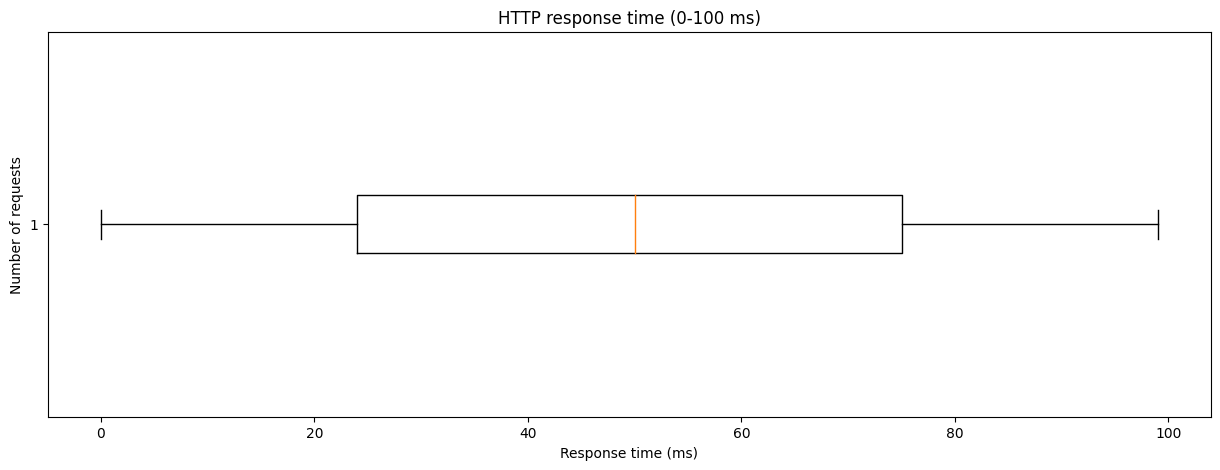

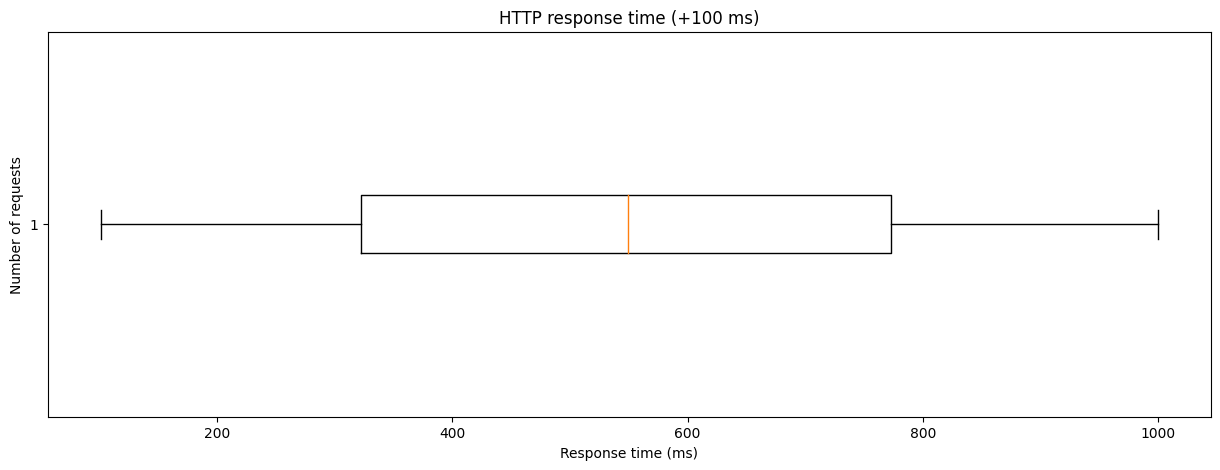

In [21]:
# Box plot of HTTP response time

# 1. 0-100 ms
plt.figure(figsize=(15, 5))
plt.title('HTTP response time (0-100 ms)')
plt.xlabel('Response time (ms)')
plt.ylabel('Number of requests')
plt.boxplot(df['time-taken'][df['time-taken'] < 100], vert=False)
plt.show()

# 2. +100 ms
plt.figure(figsize=(15, 5))
plt.title('HTTP response time (+100 ms)')
plt.xlabel('Response time (ms)')
plt.ylabel('Number of requests')
plt.boxplot(df['time-taken'][df['time-taken'] > 100], vert=False)
plt.show()

In [22]:
# Summarizing table
table = pd.DataFrame(columns=['Total', 'Daily average'])
table.loc['Requests'] = [totalrequests.sum().astype(int), meanrequests.sum().astype(int)]

# Request types
for m in totalrequests.index:
    table.loc[m.upper()] = [totalrequests[m].astype(int), meanrequests[m].astype(int)]

# Top 5 Status codes
for s in statuscodes.index[:5]:
    table.loc['Status code {}'.format(s)] = [statuscodes[s], (statuscodes[s] / len(df['date'].unique())).astype(int)]
    
# HTTP vs HTTPS
table.loc['HTTP'] = [http.shape[0], round(http.shape[0] / len(df['date'].unique()))]
table.loc['HTTPS'] = [https.shape[0], round(https.shape[0] / len(df['date'].unique()))]

table

,Total,Daily average
Requests,77996,5194
CONNECT,2037,135
DELETE,1928,128
GET,39107,2607
HEAD,1964,130
OPTIONS,5969,397
PATCH,3835,255
POST,7784,518
PUT,7605,507
TRACE,7767,517


## IPs

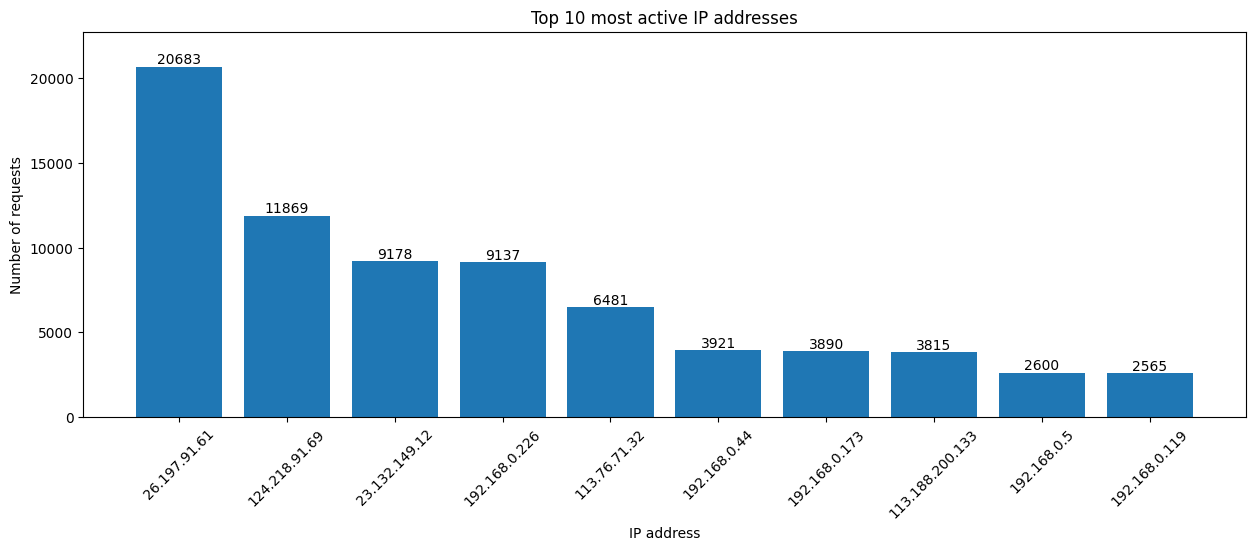

In [23]:
# Plot of top 10 most active IP addresses
plt.figure(figsize=(15, 5))
plt.title('Top 10 most active IP addresses')
plt.xlabel('IP address')
plt.ylabel('Number of requests')
topips = df['c-ip'].value_counts()[:10]
plt.bar(topips.index, topips)
plt.xticks(rotation=45)
plt.ylim(0, topips.max() * 1.1)

for i, v in enumerate(topips):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

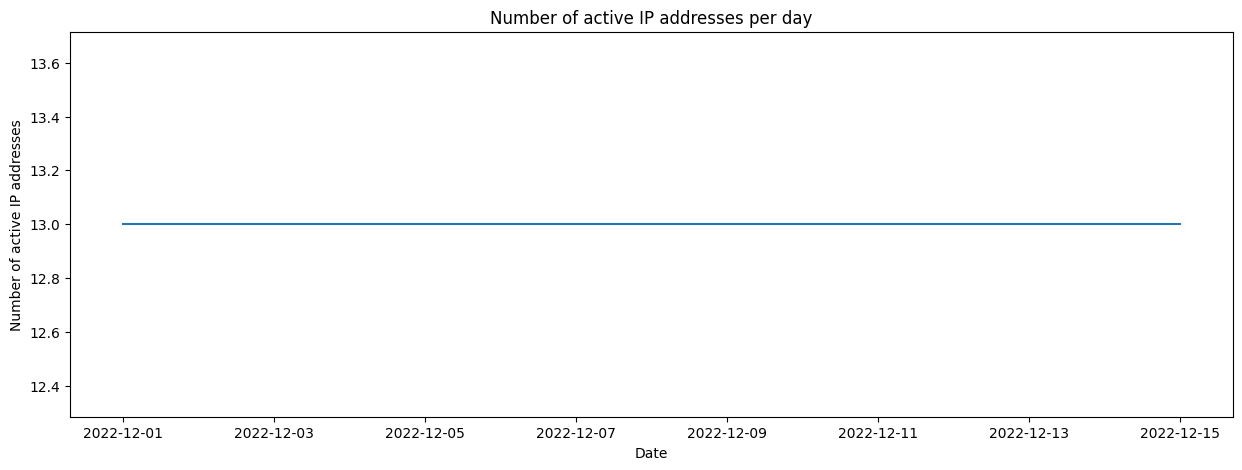

In [24]:
# Plot of number of active IP addresses per day
plt.figure(figsize=(15, 5))
plt.title('Number of active IP addresses per day')
plt.xlabel('Date')
plt.ylabel('Number of active IP addresses')
plt.plot(df['date'].unique(), df.groupby('date')['c-ip'].nunique())
plt.show()

## Pages

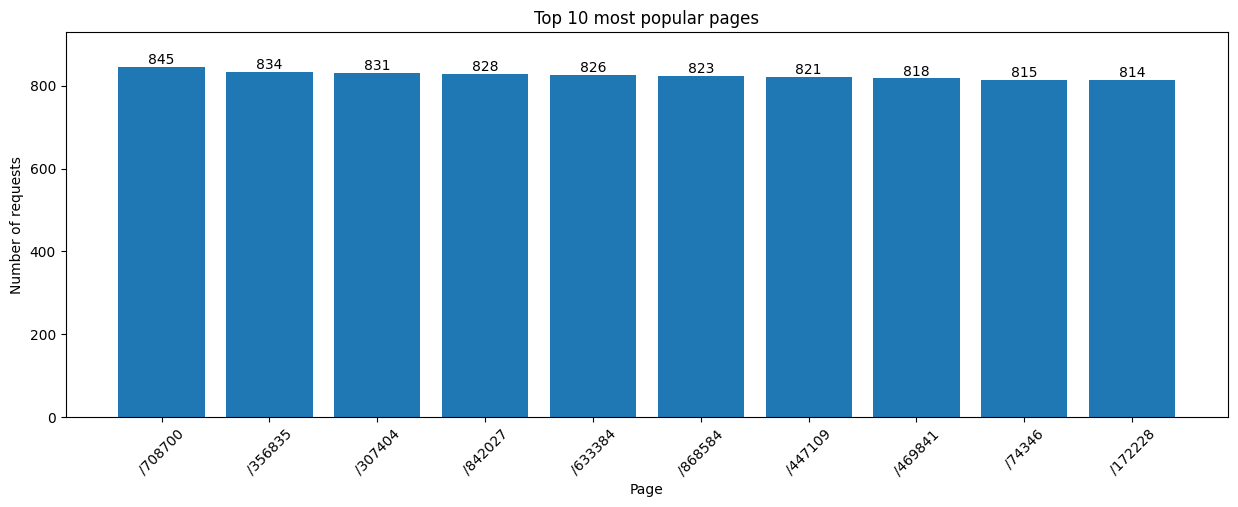

In [25]:
# Bar plot of top 10 most popular pages
plt.figure(figsize=(15, 5))
plt.title('Top 10 most popular pages')
plt.xlabel('Page')
plt.ylabel('Number of requests')
toppages = df['cs-uri-stem'].value_counts()[:10]
plt.bar(toppages.index, toppages)
plt.xticks(rotation=45)
plt.ylim(0, toppages.max() * 1.1)

for i, v in enumerate(toppages):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()